In [6]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add parent directory to sys.path
sys.path.append(parent_dir)

print(parent_dir)

/home/adam/dev/gradual-aacbr/examples


In [7]:
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

import deeparguing.gradual_aacbr as gradual_aacbr
import deeparguing.semantics.relu_semantics as rs
import deeparguing.semantics.sigmoid_semantics as ss
import deeparguing.base_scores.learned_base_score as lbs
import deeparguing.base_scores.constant_base_score as cbs
import deeparguing.casebase_edge_weights.learned_partial_order as lpo
import deeparguing.irrelevance_edge_weights.regular_irrelevance as ri
import deeparguing.feature_extractor.feature_weighted_extractor as fwe
import deeparguing.feature_extractor.mlp_extractor as mlpe
import deeparguing.casebase_edge_weights.compute_partial_order as cpo
import deeparguing.feature_extractor.scaler as scaler

from deeparguing.train import evaluate_model, static_train_model
from deeparguing.regulariser import sparsity_regulariser, community_preservation_regulariser, connectivity_regulariser, feature_smoothness_regulariser, regularise


from helper import load_mushroom, split_data, normalise_input

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# SEED = 42
SEED = 1

### DATA SET

In [10]:
X, y = load_mushroom()

X = X.astype(np.float32)
np.random.seed(SEED)
indices = np.random.permutation(len(X))

X = X[indices]
y = y[indices]

print(X.shape)

all_y = np.unique(y, axis=0)
print(all_y)

(8124, 117)
[[0. 1.]
 [1. 0.]]


In [11]:
# full_train_size = 625
full_train_size = 250
train_size = int(full_train_size * 0.8)

# train_full, train, val, test = split_data(X, y, SEED)

# print(f"Test Size:  {len(test['X'])}")
# print(f"Train Size:  {len(train['X'])}")
# print(f"Validation Size:  {len(val['X'])}")

train_full = {"X": X[:full_train_size], "y": y[:full_train_size]}
train = {"X": X[:train_size], "y": y[:train_size]}
val = {"X": X[train_size:full_train_size], "y": y[train_size:full_train_size]}
test = {"X": X[full_train_size:], "y": y[full_train_size:]}

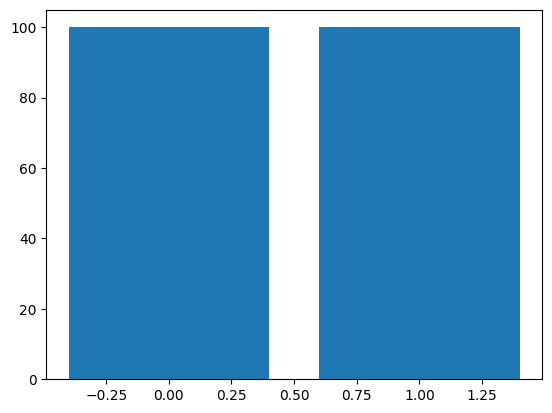

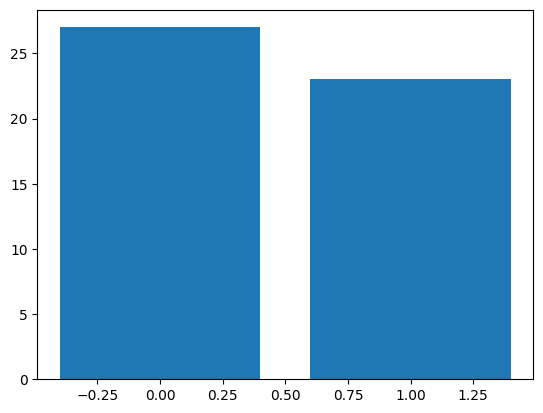

In [12]:
result = np.unique(train['y'], axis=0, return_counts=True)
plt.bar(x =np.argmax(result[0], axis=1) , height = result[1])
plt.show()

result = np.unique(val['y'], axis=0, return_counts=True)
plt.bar(x =np.argmax(result[0], axis=1) , height = result[1])
plt.show()

In [13]:
X_train_full, y_train_full = torch.tensor(train_full["X"], device=device),      torch.tensor(train_full["y"], dtype=torch.float32, device=device)
X_train, y_train           = torch.tensor(train["X"]     , device=device),      torch.tensor(train["y"],      dtype=torch.float32, device=device)
X_val, y_val               = torch.tensor(val["X"]       , device=device),      torch.tensor(val["y"],        dtype=torch.float32, device=device)
X_test, y_test             = torch.tensor(test["X"]      , device=device),      torch.tensor(test["y"],       dtype=torch.float32, device=device)

In [14]:
# train_mean = X_train.mean(dim=0)
# train_std = X_train.std(dim=0)


# X_train = normalise_input(X_train, train_mean, train_std)
# X_val = normalise_input(X_val, train_mean, train_std)
# X_test = normalise_input(X_test, train_mean, train_std)

### TRAIN MODEL

In [15]:
# DEFAULT_CASE = X_train.mean(axis=0)
DEFAULT_CASE = torch.zeros(X_train.shape[1]).to(device=device)

X_DEFAULTS = DEFAULT_CASE.tile(len(all_y), 1)
Y_DEFAULTS = torch.tensor(all_y, device=device).flip([0])

In [16]:
MAX_ITERS = len(X_train)
# MAX_ITERS = 100
# MAX_ITERS = 351
EPOCHS = 500
# EPOCHS = 3000
USE_SYMMETRIC_ATTACKS = False
LR = 2e-2
TEMPERATURE = 0.05
USE_BLOCKERS = True
# USE_BLOCKERS = False
USE_SUPPORTS = True

ALPHA = 0
BETA = 0
GAMMA = 0.005

# BATCH_SIZE = 1500
# BLOCKERS_BATCH_SIZE = 20
FE_BATCH_SIZE = 10
BLOCKERS_BATCH_SIZE = 1

In [17]:
print(MAX_ITERS)
# MAX_ITERS = 100

200


In [18]:
import random
# torch_seed = random.randint(0, 100)
# torch_seed = 0
torch_seed = 0
# print(torch_seed)
torch.manual_seed(torch_seed) # TRY DIFFERENT INITIAL WEIGHTS 

In [19]:
no_features = X_train.shape[-1]
semantics = rs.ReluSemantics(max_iters=MAX_ITERS, epsilon=0)

pofe = fwe.FeatureWeightedExtractor(no_features)
bsfe = pofe
bs_scaler = scaler.Scaler(bsfe.get_output_features(), weight=1.0)
comp_func = cpo.Subtractor(temperature=TEMPERATURE, activation=torch.sigmoid)

partial_order = lpo.LearnedPartialOrder([pofe], comparison_func=comp_func, batch_size=FE_BATCH_SIZE)
irrelevance = ri.RegularIrrelevance(partial_order)
base_score = lbs.LearnedBaseScore([bsfe, bs_scaler], activation=torch.sigmoid, batch_size=FE_BATCH_SIZE)

model = gradual_aacbr.GradualAACBR(semantics, 
                                base_score,
                                irrelevance,
                                partial_order,
                                batch_size=BLOCKERS_BATCH_SIZE).to(device)

In [20]:
regulariser = lambda model: regularise(model, [
    # [sparsity_regulariser, ALPHA], 
    # [connectivity_regulariser, BETA], 
    [community_preservation_regulariser, GAMMA],
    # [feature_smoothness_regulariser, alpha]
    ])

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [22]:
def uni_directional(A):

    A = torch.where(torch.abs(A) > torch.abs(A.T), A, 0)
    return A

POST_PROCESS_FUNC = uni_directional
# POST_PROCESS_FUNC = lambda x: x

RESULTS ON VALIDATION SET PRE TRAINING
Accuracy, Precision, Recall, F1
(0.46, np.float64(0.23), np.float64(0.5), np.float64(0.3150684931506849))


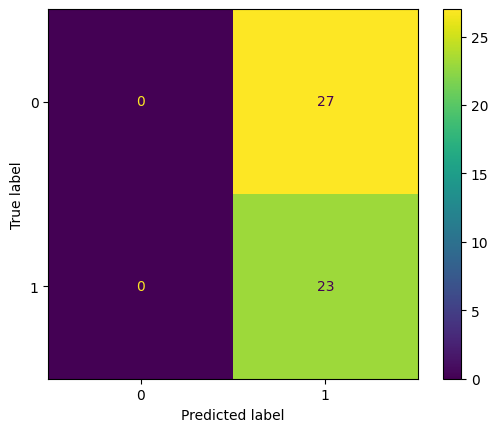

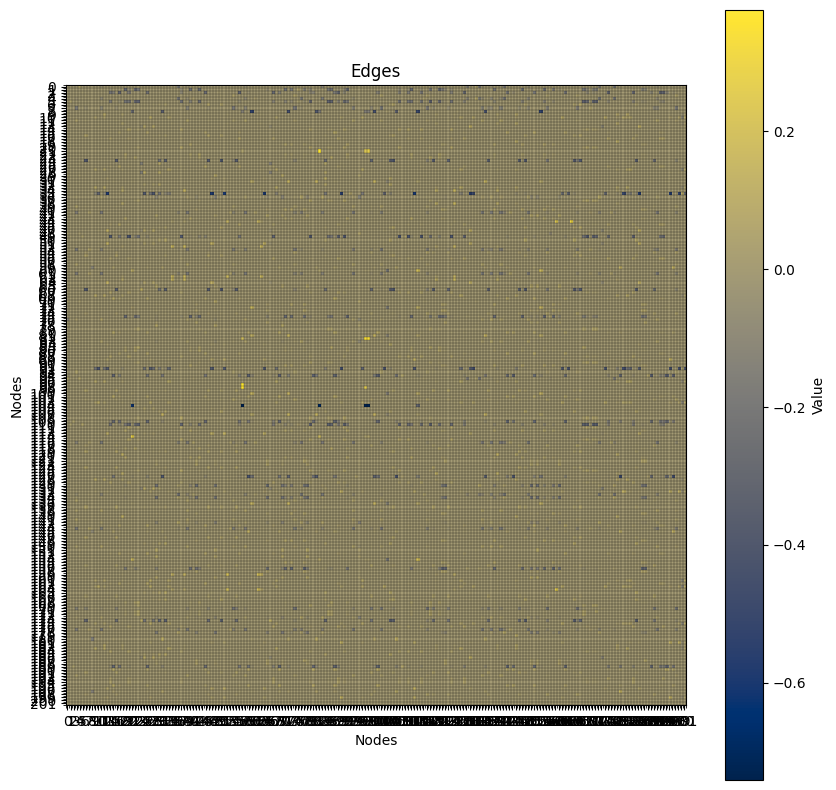

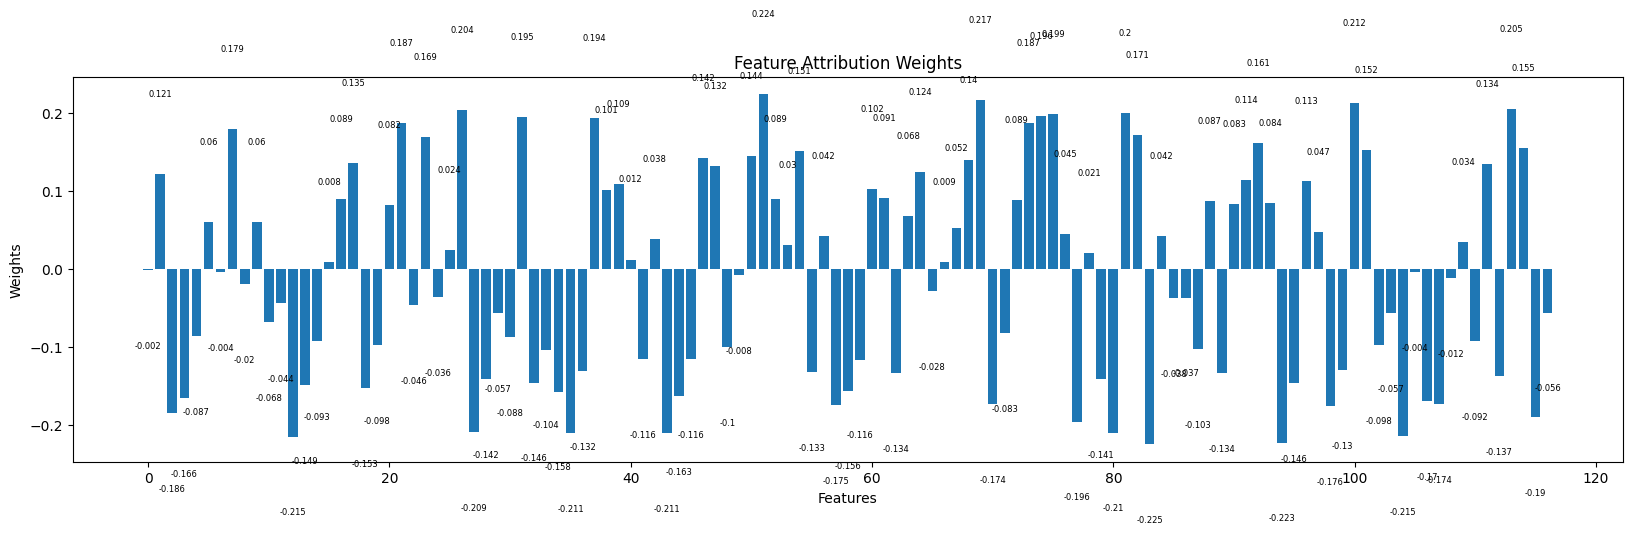

SCALE FACTOR Parameter containing:
tensor(1., device='cuda:0', requires_grad=True)


In [23]:
print("RESULTS ON VALIDATION SET PRE TRAINING")
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS, 
                                                     X_val, y_val, show_confusion=True, use_blockers=USE_BLOCKERS,  
                                                     print_matrix=True, print_compute_graph=False, 
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)

    model.plot_base_score_parameters()    

Epoch 500, Loss: 0.361096: 100%|██████████| 500/500 [00:34<00:00, 14.43it/s]


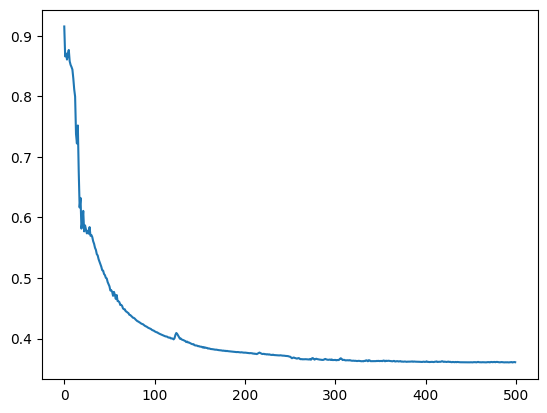

In [24]:
losses = static_train_model(model, X_train, y_train, 
                X_DEFAULTS, Y_DEFAULTS, optimizer, 
                criterion, EPOCHS, X_new_cases=X_train, y_new_cases=y_train, 
                use_symmetric_attacks=False, use_blockers=USE_BLOCKERS, 
                plot_loss_curve=True,
                disable_tqdm=False, post_process_func=POST_PROCESS_FUNC, regularise_graph=regulariser,
                use_supports=USE_SUPPORTS)

RESULTS ON VALIDATION SET POST TRAINING
Accuracy, Precision, Recall, F1
(0.96, np.float64(0.9597423510466989), np.float64(0.9597423510466989), np.float64(0.9597423510466989))


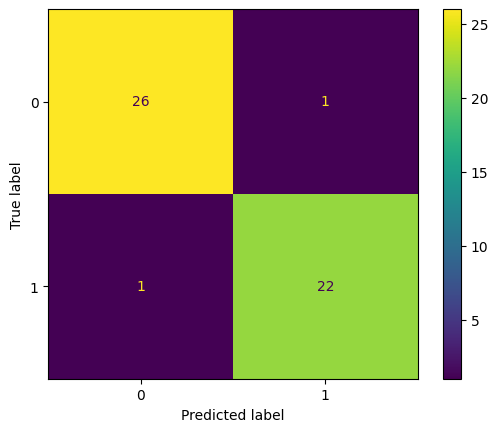

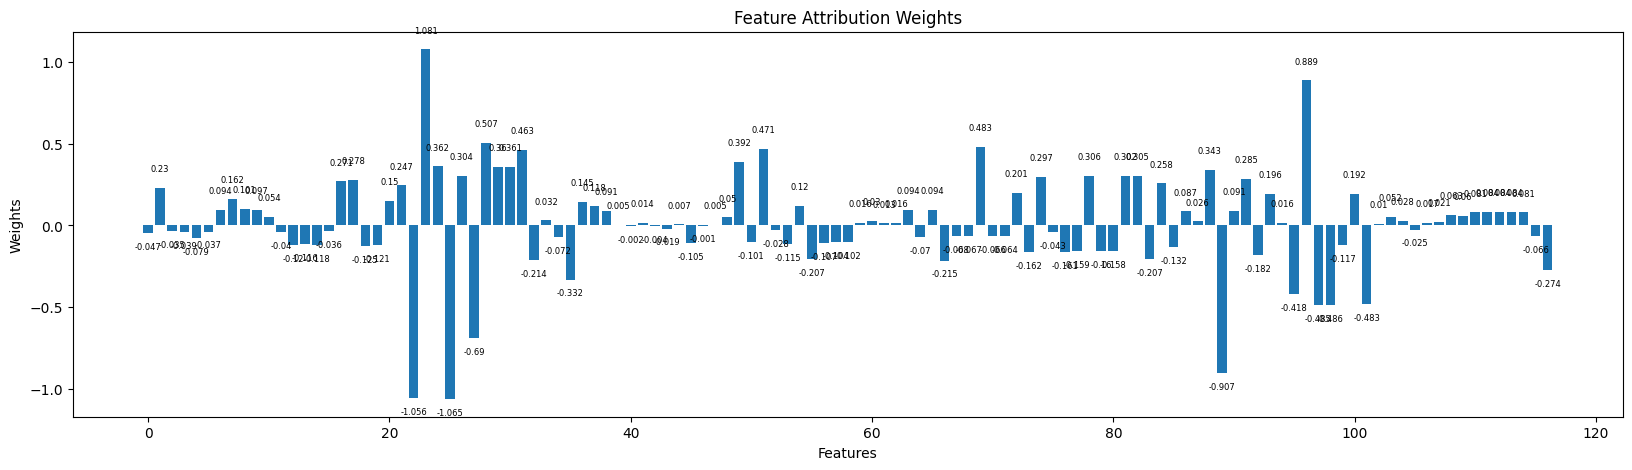

SCALE FACTOR Parameter containing:
tensor(4.5206, device='cuda:0', requires_grad=True)


In [27]:
print("RESULTS ON VALIDATION SET POST TRAINING")
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS, 
                                                     X_val, y_val, show_confusion=True, use_blockers=USE_BLOCKERS,  
                                                     print_matrix=False, print_compute_graph=False, 
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)
    model.plot_base_score_parameters()

In [26]:
assert(False)

AssertionError: 

Accuracy, Precision, Recall, F1
(0.976504953009906, np.float64(0.9764531820631798), np.float64(0.976496735981686), np.float64(0.9764745637771655))


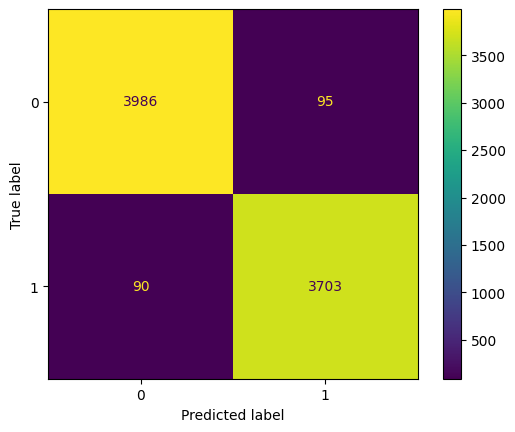

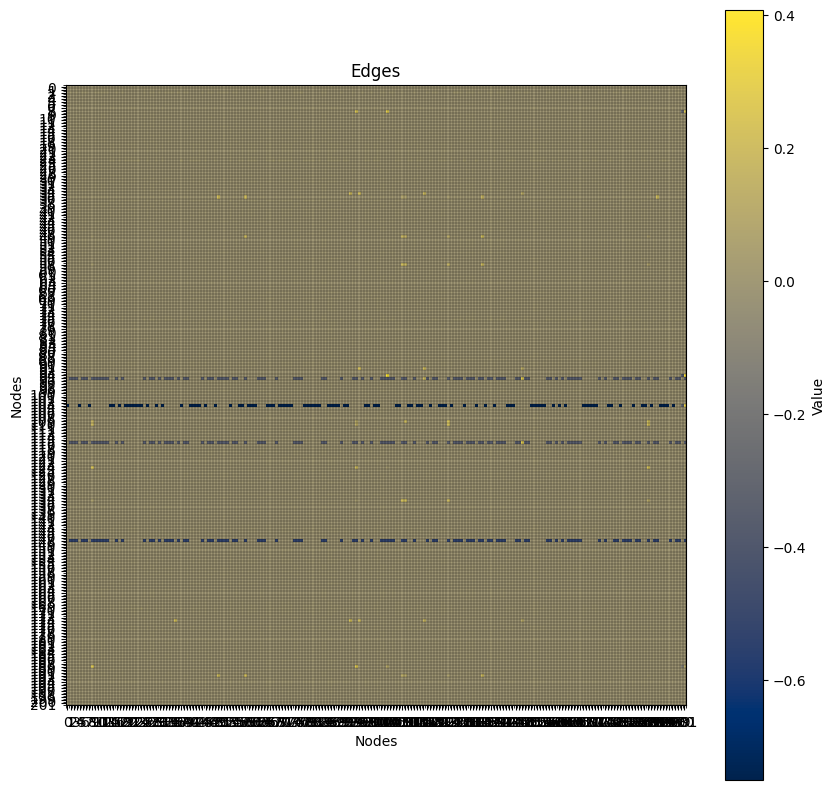

In [28]:
with torch.no_grad():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_DEFAULTS, Y_DEFAULTS, 
                                                     X_test, y_test, show_confusion=True, use_blockers=USE_BLOCKERS,  
                                                     print_matrix=True, print_compute_graph=False, 
                                                     print_graph=False, print_results=True, post_process_func=POST_PROCESS_FUNC,
                                                     use_supports=USE_SUPPORTS)